In [1]:
import opensense_data_downloader_and_transformer as oddt

In [2]:
oddt.download_overeem_2019_large_CML_data_Netherlands(
    local_path='overeem_2019_large_CML_data_Netherlands', 
    print_output=True,
)

to overeem_2019_large_CML_data_Netherlands/data.zip


('overeem_2019_large_CML_data_Netherlands/data.zip',
 <http.client.HTTPMessage at 0x109796740>)

In [3]:
ds_overeem_2019 = oddt.transform_overeem_2019_large_CML_data_Netherlands(
    fn='overeem_2019_large_CML_data_Netherlands/data.zip', 
    nrows=1e6,
)

cml 295 has 342 duplicated entries from 684 rows.
cml 319 has 342 duplicated entries from 684 rows.
cml 341 has 342 duplicated entries from 684 rows.
cml 369 has 340 duplicated entries from 685 rows.
cml 602 has 343 duplicated entries from 686 rows.
cml 857 has 345 duplicated entries from 691 rows.
cml 892 has 343 duplicated entries from 686 rows.
cml 928 has 344 duplicated entries from 688 rows.
cml 1039 has 345 duplicated entries from 690 rows.
cml 1133 has 336 duplicated entries from 681 rows.
cml 1146 has 345 duplicated entries from 690 rows.
cml 1442 has 342 duplicated entries from 685 rows.
cml 1737 has 346 duplicated entries from 692 rows.
cml 1805 has 337 duplicated entries from 679 rows.
cml 1910 has 345 duplicated entries from 690 rows.
cml 1996 has 342 duplicated entries from 684 rows.
cml 2079 has 345 duplicated entries from 690 rows.
cml 2099 has 342 duplicated entries from 684 rows.
cml 2109 has 342 duplicated entries from 684 rows.
cml 2310 has 345 duplicated entries fro

In [4]:
ds_overeem_2019

<xarray.Dataset>
Dimensions:           (time: 346, cml_id: 2908)
Coordinates:
  * time              (time) datetime64[ns] 2012-05-30T00:15:00 ... 2012-06-0...
  * cml_id            (cml_id) int64 1 2 3 4 5 6 ... 2904 2905 2906 2907 2908
    length            (cml_id) float64 6.285 3.318 2.546 ... 4.613 1.952 1.441
    frequency         (cml_id) float64 25.35 37.98 39.17 ... 37.98 39.17 39.38
    site_a_longitude  (cml_id) float64 3.854 3.811 3.843 ... 4.465 5.475 4.892
    site_b_longitude  (cml_id) float64 3.775 3.792 3.854 ... 4.4 5.465 4.871
    site_a_latitude   (cml_id) float64 51.76 51.43 51.74 ... 52.1 51.39 52.35
    site_b_latitude   (cml_id) float64 51.73 51.4 51.76 ... 52.08 51.41 52.35
Data variables:
    pmin              (cml_id, time) float64 -53.0 -53.0 -53.0 ... nan nan nan
    pmax              (cml_id, time) float64 -53.0 -52.0 -53.0 ... nan nan nan

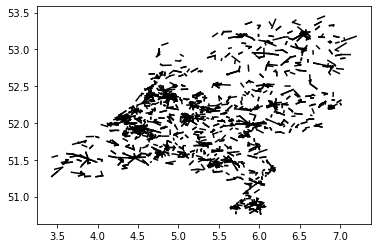

In [5]:
import matplotlib.pyplot as plt
for lon1, lat1, lon2, lat2 in zip(
    ds_overeem_2019.site_a_longitude, 
    ds_overeem_2019.site_a_latitude,
    ds_overeem_2019.site_b_longitude, 
    ds_overeem_2019.site_b_latitude):
    
    plt.plot([lon1, lon2], [lat1, lat2], "-", c="black")

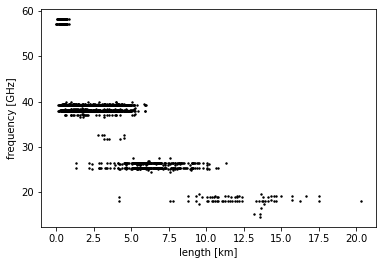

In [6]:
plt.scatter(ds_overeem_2019.length.values,ds_overeem_2019.frequency.values,s=2,color='black')
plt.xlabel("length [km]")
plt.ylabel("frequency [GHz]");

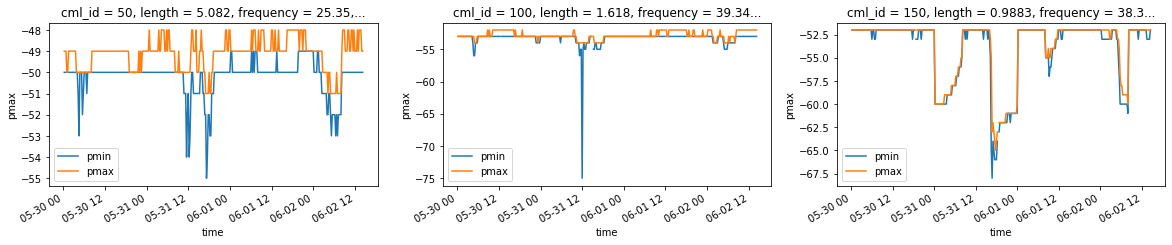

In [7]:
fig,ax=plt.subplots(ncols=3,figsize=(20,3))
for i,j in zip([49,99,149],[0,1,2]):
    ds_overeem_2019.isel(cml_id=i).pmin.plot(label="pmin",ax=ax[j])
    ds_overeem_2019.isel(cml_id=i).pmax.plot(label="pmax",ax=ax[j])
    ax[j].legend()